In [1]:
# Load packages

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import os

# Conda packages used for virtual environment:
# pandas numpy geopandas rasterio contextily fiona ipykernel matplotlib seaborn xarray geowombat rasterstats os

## Getting Geospatial Data

In [2]:
# Import 2018 Congressional data

# Unzip Congressional district shapefile data

path = "../data_2018/2018_us_cd116"

if not os.path.exists(path):
    with zipfile.ZipFile("./data_2018/2018_us_cd116.zip", "r") as zip_ref:
        zip_ref.extractall("./data_2018/2018_us_cd116")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

Unzipped folder already exists. Skipping extraction.


In [4]:
# Get congressional district spatial data
gdf_cd = gpd.read_file("../data_2018/2018_us_cd116/tl_2018_us_cd116.shp")

# Filter to Ohio (39), Indiana (18), Michigan (26), Pennslyvania (42), Wisconsin (55), & Missiouri (29)
gdf_cd = gdf_cd[gdf_cd['STATEFP'].isin(['18', '26', '29', '39', '42', '55'])]

state_map = {
    '39': 'Ohio',
    '18': 'Indiana',
    '26': 'Michigan',
    '42': 'Pennsylvania',
    '55': 'Wisconsin',
    '29': 'Missouri'
}

gdf_cd.head()

gdf_cd['STATE'] = gdf_cd['STATEFP'].map(state_map)
gdf_cd['CD116'] = gdf_cd['STATE'] + ' ' + gdf_cd['CD116FP']

# Limit to specified columns
columns_gdf_cd = ['CD116', 'GEOID', 'geometry']
gdf_cd = gdf_cd[columns_gdf_cd]

# Preview
print(gdf_cd.head())

         CD116 GEOID                                           geometry
15  Indiana 02  1802  POLYGON ((-86.93100 40.95794, -86.93100 40.958...
16  Indiana 09  1809  POLYGON ((-86.68566 39.32122, -86.68569 39.322...
17  Indiana 06  1806  POLYGON ((-86.08560 39.34419, -86.08524 39.344...
18  Indiana 08  1808  POLYGON ((-88.09776 37.90403, -88.09566 37.905...
30  Indiana 01  1801  POLYGON ((-87.52676 41.30832, -87.52674 41.311...


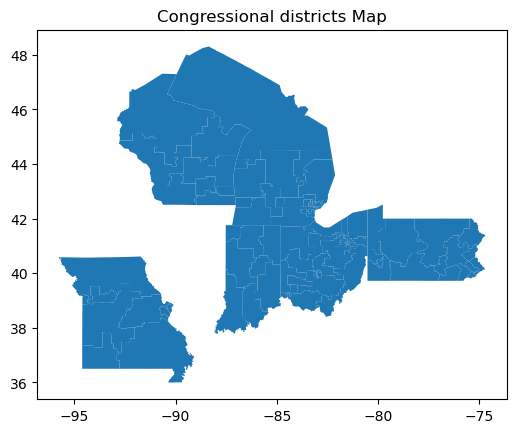

In [5]:
# Reprojecting to epsg:4326

gdf_cd_proj = gdf_cd.to_crs(epsg=4326)

# Map reprojected data
gdf_cd_proj.plot()
plt.title("Congressional districts Map")
plt.show()

In [ ]:
gdf_cd_proj.head()

,CD116,GEOID,geometry
15,Indiana 02,1802,"POLYGON ((-86.93100 40.95794, -86.93100 40.958..."
16,Indiana 09,1809,"POLYGON ((-86.68566 39.32122, -86.68569 39.322..."
17,Indiana 06,1806,"POLYGON ((-86.08560 39.34419, -86.08523 39.344..."
18,Indiana 08,1808,"POLYGON ((-88.09776 37.90402, -88.09566 37.905..."
30,Indiana 01,1801,"POLYGON ((-87.52676 41.30832, -87.52673 41.311..."


### 2018 Land Coverage data

Data gathered from https://www.mrlc.gov/

Files were too large so had to be deleted from computer.

In [ ]:
# Get land coverage data

# Unzip Ohio area land coverage data
path = "../data_2018/land_coverage_2018"

if not os.path.exists(path):
    with zipfile.ZipFile("../data_2018/land_coverage_2018.zip", "r") as zip_ref:
        zip_ref.extractall("../data_2018/land_coverage_2018")
        print("Unzipped successfully.")
else:
    print("Unzipped folder already exists. Skipping extraction.")

Unzipped successfully.


In [8]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from shapely.geometry import mapping

# Get land coerage data
tif_path = "../data_2018/land_coverage_2018/Annual_NLCD_LndCov_2018_CU_C1V1_4M99LON17KLTTUbIr9km.tiff"

# Reproject land coverage data onto ESPG: 4326
dst_crs = 'EPSG:4326'
reprojected_tif_path = "../data_2018/land_coverage_reprojected.tif"

with rasterio.open(tif_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

# Create new reprojected .tif file called: land_coverage_reprojected.tif
    with rasterio.open(reprojected_tif_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


In [ ]:
# import rasterio
# import matplotlib.pyplot as plt

# # Open the TIFF file
# with rasterio.open("../data_2018/land_coverage_reprojected.tif") as src:
#     image = src.read(1)  # Read the first band

# # Preview to ensure reprojection was successful (optional)
# plt.imshow(image)
# plt.colorbar()
# plt.title("GeoTIFF Band 1")
# plt.show()

In [9]:
# Get land coverage .tif file
raster_path = "../data_2018/land_coverage_reprojected.tif"

# Get geometry data for each congressional district
urbanization_cd_gdf = gdf_cd_proj.copy()
# cd_geom.head(20)

# Make sure they have the same projection
with rasterio.open("../data_2018/land_coverage_reprojected.tif") as src:
    print(src.crs)
    print(urbanization_cd_gdf.crs)

EPSG:4326
EPSG:4326


In [10]:
from rasterstats import zonal_stats

# Get pixel value counts per district
stats = zonal_stats(
    vectors=urbanization_cd_gdf,
    raster=raster_path,
    stats=None,  # no mean/sum, just raw counts
    categorical=True,
    nodata=0  # exclude nodata pixels (adjust if your nodata value is different)
)


In [11]:
# Add stats to the GeoDataFrame
urbanization_cd_gdf["dev_21"] = [s.get(21, 0) for s in stats]
urbanization_cd_gdf["dev_22"] = [s.get(22, 0) for s in stats]
urbanization_cd_gdf["dev_23"] = [s.get(23, 0) for s in stats]
urbanization_cd_gdf["dev_24"] = [s.get(24, 0) for s in stats]

# Add total developed area (pixel count)
urbanization_cd_gdf["dev_total"] = urbanization_cd_gdf[["dev_21", "dev_22", "dev_23", "dev_24"]].sum(axis=1)

# Total land pixels per district
urbanization_cd_gdf["total_pixels"] = [sum(s.values()) for s in stats]

# Calculate % developed for a measure of urbanization
urbanization_cd_gdf["urbanization_pct"] = (urbanization_cd_gdf["dev_total"] / urbanization_cd_gdf["total_pixels"]) * 100

urbanization_cd_gdf.head(20)


,CD116,GEOID,geometry,dev_21,dev_22,dev_23,dev_24,dev_total,total_pixels,urbanization_pct
15,Indiana 02,1802,"POLYGON ((-86.93100 40.95794, -86.93100 40.958...",636860,670721,219092,78621,1605294,10911740,14.711623
16,Indiana 09,1809,"POLYGON ((-86.68566 39.32122, -86.68569 39.322...",803100,440098,172504,43860,1459562,11933460,12.230837
17,Indiana 06,1806,"POLYGON ((-86.08560 39.34419, -86.08523 39.344...",823850,760044,198975,49759,1832628,16571110,11.059175
18,Indiana 08,1808,"POLYGON ((-88.09776 37.90402, -88.09566 37.905...",1045461,711693,251261,61775,2070190,19328337,10.710647
30,Indiana 01,1801,"POLYGON ((-87.52676 41.30832, -87.52673 41.311...",271283,374872,259600,96694,1002449,3819869,26.243020
107,Indiana 03,1803,"POLYGON ((-85.91121 41.26195, -85.90140 41.262...",424095,885981,265491,69994,1645561,11493837,14.316899
108,Indiana 05,1805,"POLYGON ((-86.35661 40.11996, -86.35660 40.121...",278312,600669,246600,53939,1179520,5204322,22.664239
109,Indiana 04,1804,"POLYGON ((-87.53145 40.14814, -87.53144 40.148...",758526,788624,247762,70606,1865518,17139332,10.884427
110,Indiana 07,1807,"POLYGON ((-86.32729 39.82249, -86.32579 39.822...",119131,243795,222622,80174,665722,813949,81.789154
156,Missouri 01,2901,"POLYGON ((-90.48133 38.76685, -90.48117 38.767...",75814,163375,182336,74294,495819,618862,80.117861


In [13]:
# Export data
urbanization_cd_gdf['urbanization_pct'] = urbanization_cd_gdf['urbanization_pct'].round(2)
urbanization_cd_gdf.to_csv('../data_2018/urbanization_2018.csv', index=False)